In [36]:
# Importamos las librerias que debemos utilizar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from google.cloud import storage
import joblib
from google.cloud import aiplatform

In [37]:
# Descargamos recursos necesarios para NLTK
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aylus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aylus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aylus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aylus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
# Cargamos datos desde Google Cloud Storage
bucket_name = "pf_cleaned_data"
blob_name = "Modelo_df/maps_concatenado3.parquet" 

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(blob_name)

# Descargamos el conjunto de datos localmente
blob.download_to_filename("modelo_df_final.parquet")

In [39]:
# Cargamos los datos 
data = pd.read_parquet('modelo_df_final.parquet')

In [40]:
data.head(3)

,Nombre,Direccion,latitude,longitude,Estrellas,city,text,state
0,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",25.779837,-80.239103,4.6,Miami,I love Choices! All their locations.. I've be...,FL
1,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",25.779837,-80.239103,4.6,Miami,Absolutely delicious! And not so badly priced....,FL
2,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",25.779837,-80.239103,4.6,Miami,Fantastic vegan & organic place in Miami. A tr...,FL


In [41]:
data.shape

(38336, 8)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38336 entries, 0 to 38335
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Nombre     38336 non-null  object 
 1   Direccion  38336 non-null  object 
 2   latitude   38336 non-null  float64
 3   longitude  38336 non-null  float64
 4   Estrellas  38336 non-null  float64
 5   city       38336 non-null  object 
 6   text       38336 non-null  object 
 7   state      38336 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.3+ MB


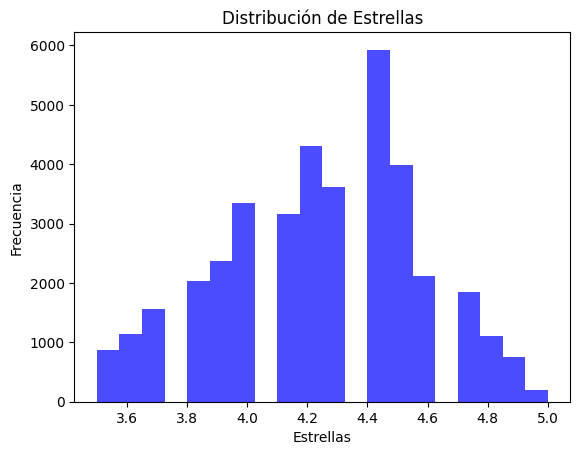

In [43]:
import matplotlib.pyplot as plt

# Histograma para avg_rating
plt.hist(data['Estrellas'], bins=20, color='blue', alpha=0.7)
plt.title('Distribución de Estrellas')
plt.xlabel('Estrellas')
plt.ylabel('Frecuencia')
plt.show()

La grafica representa la distribucion de la calificacion media para cada restaurant, observandose que el promedio de calificaciones se encuentra en 4.5

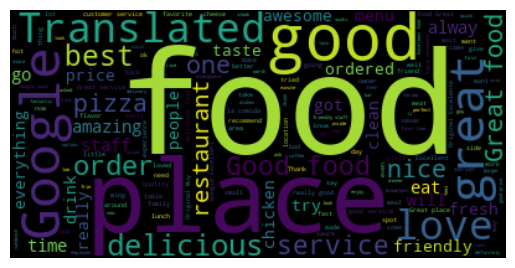

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate(' '.join(data['text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

En esta grafica se busca obtener las palabras que mas aparecen en las reviews de los comensales, obteniendo como ejemplo: 'good','food','great', etc

Para una optimizacion del modelo seleccionaremos solo columnas que son indispensables para el mismo

In [45]:
columnas_elegidas = ['Nombre','Direccion','Estrellas','city','text']
data = data[columnas_elegidas].copy()

In [46]:
data.head(3)

,Nombre,Direccion,Estrellas,city,text
0,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,I love Choices! All their locations.. I've be...
1,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,Absolutely delicious! And not so badly priced....
2,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,Fantastic vegan & organic place in Miami. A tr...


In [47]:
data.shape

(38336, 5)

In [48]:
# Realizamos el analisis de sentimiento usando NLTK
sia = SentimentIntensityAnalyzer()

def obtener_polaridad(reseña):
    sentiment_score = sia.polarity_scores(reseña)
    return sentiment_score['compound']

data['polaridad'] = data['text'].apply(obtener_polaridad)

In [49]:
# Verificamos que se haya creado la columna de polaridad correctamente
data.head(3)

,Nombre,Direccion,Estrellas,city,text,polaridad
0,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,I love Choices! All their locations.. I've be...,0.8787
1,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,Absolutely delicious! And not so badly priced....,0.9059
2,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,Fantastic vegan & organic place in Miami. A tr...,0.9528


In [50]:
# tokenización y lematización
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def procesar_texto(texto):
    tokens = word_tokenize(texto.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)


**Tokenización y Lematización:**

La **tokenización** divide un texto en unidades (tokens), facilitando el análisis palabra por palabra. Por otro lado, la **lematización** reduce palabras a su forma base, simplificando el procesamiento al eliminar variaciones. Ambos procesos son cruciales en NLP para garantizar consistencia, reducir la dimensionalidad y mejorar el análisis semántico del texto.


In [51]:
# Procesamos el texto
data['reseña_procesada'] = data['text'].apply(procesar_texto)
data.head(3)

,Nombre,Direccion,Estrellas,city,text,polaridad,reseña_procesada
0,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,I love Choices! All their locations.. I've be...,0.8787,love choice location vegan year month eat leas...
1,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,Absolutely delicious! And not so badly priced....,0.9059,absolutely delicious badly priced totally full...
2,Choices Cafe,"711 NW 27th Ave, Miami, FL 33125",4.6,Miami,Fantastic vegan & organic place in Miami. A tr...,0.9528,fantastic vegan organic place miami truly gem ...


**Elección del Modelo KNN**

El modelo KNN (k-vecinos más cercanos) se selecciona por su simplicidad y eficacia en problemas de clasificación y regresión. Su enfoque de "aprender de los vecinos más cercanos" se adapta bien a conjuntos de datos pequeños a medianos. Es fácil de entender y no asume distribuciones específicas, siendo versátil para diferentes tipos de datos.

**Similitud de coseno** <br>
La similitud de coseno compara cuán parecidos son dos textos. Mide la dirección y magnitud de las palabras utilizadas, ayudando a encontrar similitudes en el significado. La similitud de coseno es utilizada como metrica del modelo de Knn por lo que se calcula internamente

In [52]:
""" # Guardar modelo en Google Cloud Storage
gcs_model_path = "gs://ruta-a-tu-modelo/modelo.joblib"
joblib.dump(knn_model, "modelo.joblib")

blob = bucket.blob("ruta-a-tu-modelo/modelo.joblib")
blob.upload_from_filename("modelo.joblib") """

' # Guardar modelo en Google Cloud Storage\ngcs_model_path = "gs://ruta-a-tu-modelo/modelo.joblib"\njoblib.dump(knn_model, "modelo.joblib")\n\nblob = bucket.blob("ruta-a-tu-modelo/modelo.joblib")\nblob.upload_from_filename("modelo.joblib") '

In [53]:
def obtener_recomendaciones( nombre_ciudad, min_estrellas):
    data_ciudad = data[(data['city'] == nombre_ciudad) & (data['Estrellas'] >= min_estrellas)]

    if data_ciudad.empty:
        return "No hay restaurantes que cumplan con los criterios."
    
    # Aplicamos la función de análisis de sentimiento a la columna 'text'
    data_ciudad['polaridad'] = data_ciudad['text'].apply(obtener_polaridad)
    
    # Aplicamos la función de procesamiento de texto a la columna 'text'
    data_ciudad['reseña_procesada'] = data_ciudad['text'].apply(procesar_texto)

    # Creamos un vectorizador TF-IDF para procesar las reseñas
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_ciudad = tfidf_vectorizer.fit_transform(data_ciudad['reseña_procesada'])

    # Creamos el modelo de vecinos más cercanos (KNN) utilizando como métrica la similitud de coseno
    knn_model = NearestNeighbors(n_neighbors=10, metric='cosine')
    knn_model.fit(tfidf_ciudad)

    # Encontramos los vecinos más cercanos 
    _, indices = knn_model.kneighbors(tfidf_ciudad)

    # Obtenemos las recomendaciones de restaurantes con nombre y dirección
    top3_recomendaciones = data_ciudad.iloc[indices[0]].head(3)[['Nombre', 'Direccion']]

    # Verificamos si los primeros dos elementos son iguales y, en ese caso, seleccionamos solo el primero
    if top3_recomendaciones.iloc[0]['Nombre'] == top3_recomendaciones.iloc[1]['Nombre']:
        top3_recomendaciones = top3_recomendaciones.iloc[1:]

    return top3_recomendaciones


In [54]:
# Probamos nuestro modelo de recomendacion
resultados = obtener_recomendaciones('Orlando', 3.5)
resultados

C:\Users\aylus\AppData\Local\Temp\ipykernel_24524\2402070402.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ciudad['polaridad'] = data_ciudad['text'].apply(obtener_polaridad)
C:\Users\aylus\AppData\Local\Temp\ipykernel_24524\2402070402.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ciudad['reseña_procesada'] = data_ciudad['text'].apply(procesar_texto)


,Nombre,Direccion
6,Subway,"588 S Alafaya Trail #30, Orlando, FL 32828"
18291,Tropical Smoothie Cafe,"12789 Waterford Lakes Pkwy, Orlando, FL 32828"
10637,Antonio's House of Pizza,"4626 S Kirkman Rd, Orlando, FL 32811"
